In [ ]:
%matplotlib inline
from setup import *

<h1>Generate feature matrix csv </h1>

In [3]:
for fconn in ['broadband_CC','alphatheta','beta','lowgamma','highgamma']:
        skip_chop = True
        skip_mayo = True
        skip_hup = False
        dilate_radius = 0
        all_base_sync = gather_base_sync_results(dilate_radius,fconn, skip_chop, skip_mayo)        
        all_base_sync = get_norm(all_base_sync)
        num_fts = all_base_sync.values()[0].values()[0].shape[0]
        
        pt_iter = 0
        patient_idx = all_base_sync.keys()
        ft_matrix = np.zeros((sum(map(lambda x: bool(x), all_base_sync.values())),num_fts+2))
        
        out_txt = 'pt_id,' #First column
        index_col = []    

        for patient_id in sorted(patient_idx):
                if(skip_chop and 'CHOP' in patient_id):
                    continue
                if(skip_mayo and 'Study' in patient_id):
                    continue
                if(skip_hup and 'HUP' in patient_id):
                    continue
                if not all_base_sync[patient_id]:
                    continue
#                 print patient_id
                index_col.append(patient_id)
                row_data = np.array((pt_iter+1,))    
                for pid,clips in sorted(all_base_sync.items(), key=lambda x:x[0]):                    
                    if(pid != patient_id):
                        continue
                    outcome = data['PATIENTS'][patient_id]['Outcome']

                    avg_data = np.array(())                    
                    for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                        res = clip_data                        
                        if(res.shape[0] == num_fts+1):
                            res = res[:num_fts]
                        try:                
                            avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                        except Exception:                
                            avg_data = np.reshape(res,(num_fts,1))                    
                    avg_data = np.nanmedian(avg_data,axis=1)

                    # Update row_data
                    row_data = np.hstack((row_data,avg_data)) 

                    # Update header
                    if(pt_iter == 0):
                        for t in range(1,num_fts+1):
                            out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
                if(get_outcome(outcome) == 'Good'):        
                    row_data = np.hstack((row_data,[0]))        
                else:
                    row_data = np.hstack((row_data,[1]))
                if(row_data.shape[0] != num_fts+2):
                    continue
                ft_matrix[pt_iter,:] = row_data
                pt_iter += 1
        out_txt += 'Outcome'

        df = pd.DataFrame(data=ft_matrix, index=index_col,columns=out_txt.split(',') )

        comp_dir = os.path.expanduser(data['COMP_DIR'])
        df.to_csv('%s/../code/data/e01A_%s.csv'%(comp_dir,fconn))

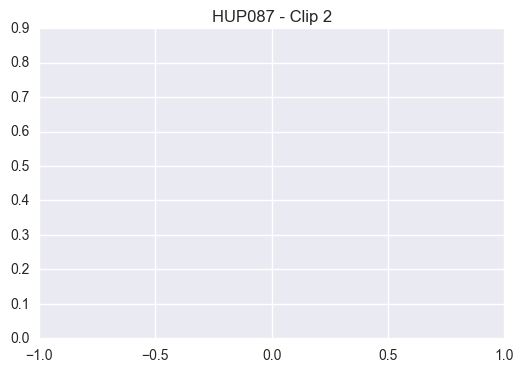

In [4]:
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')

fconn = 'lowgamma'
dilate_radius = 0
all_base_sync = gather_base_sync_results(dilate_radius,fconn, skip_chop, skip_mayo)
all_base_sync = get_norm(all_base_sync)
num_fts = all_base_sync.values()[0].values()[0].shape[0]
skip_chop = True
skip_mayo = False
skip_hup = False

pt_iter = 0

patient_idx = all_base_sync.keys()
out_txt = 'pt_id,' #First column
index_col = []    
outcomex = []
labels = []
all_data = np.array(())
for patient_id in sorted(patient_idx):
        if(skip_chop and 'CHOP' in patient_id):
            continue
        if(skip_mayo and 'Study' in patient_id):
            continue
        if(skip_hup and 'HUP' in patient_id):
            continue
        if not all_base_sync[patient_id]:
            continue
        index_col.append(patient_id)
        row_data = np.array((pt_iter+1,))
        for pid,clips in sorted(all_base_sync.items(), key=lambda x:x[0]):                    
            if(pid != patient_id):
                continue
            outcome = data['PATIENTS'][patient_id]['Outcome']
            
            for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                res = clip_data
                if(res.shape[0] == num_fts+1):
                    res = res[:num_fts]
                try:                
                    all_data = np.hstack((all_data,np.reshape(res,(num_fts,1))))
                except Exception:                
                    all_data = np.reshape(res,(num_fts,1))   
                if(get_outcome(outcome) == 'Good'):        
                    outcomex.append(0)
                else:
                    outcomex.append(1)
                labels.append('%s - Clip %s'%(pid, clip))
outcomex = np.array(outcomex)
labels = np.array(labels)
all_data = all_data.T

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
ax.set_xlim(( -1.0, 1.0))
ax.set_ylim((0, 0.9))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)
# animation function. This is called sequentially
def animate(i):
    x = np.linspace(-1.0,1.0,num_fts)
    y = all_data[i,:]
    line.set_data(x, y)
    if(outcomex[i] == 1):
        line.set_color('red')
    else:
        line.set_color('blue')   
    line.set_alpha(0.2)
    ax.set_title(labels[i])
    return (line,)
# call the animator. blit=True means only re-draw the parts that have changed.
plt.hold(True)
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=all_data.shape[0], interval=200, blit=False)
anim
# anim.save('../fig/e01A_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

<h1> Synchronizability of Time-Varying Functional Networks (across patients)</h1>

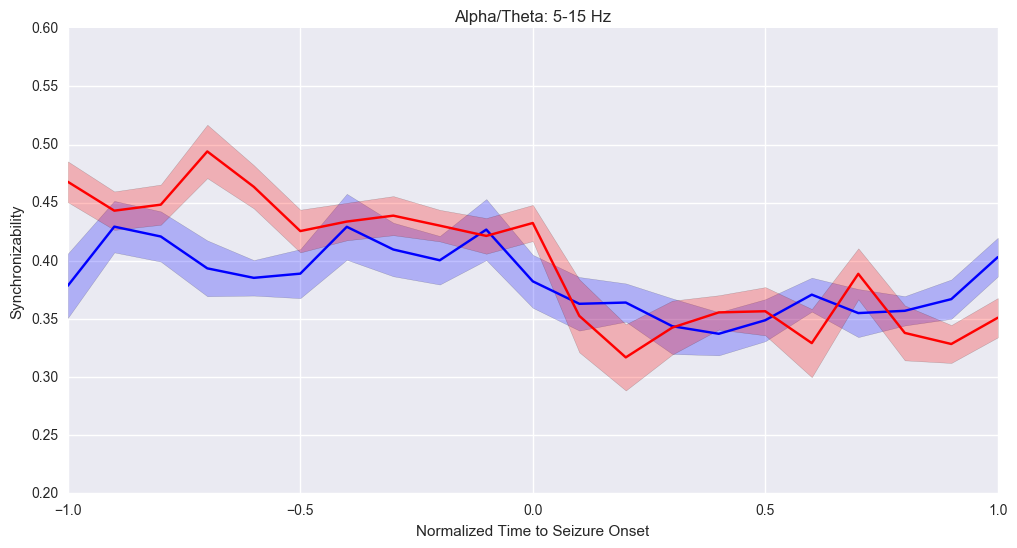

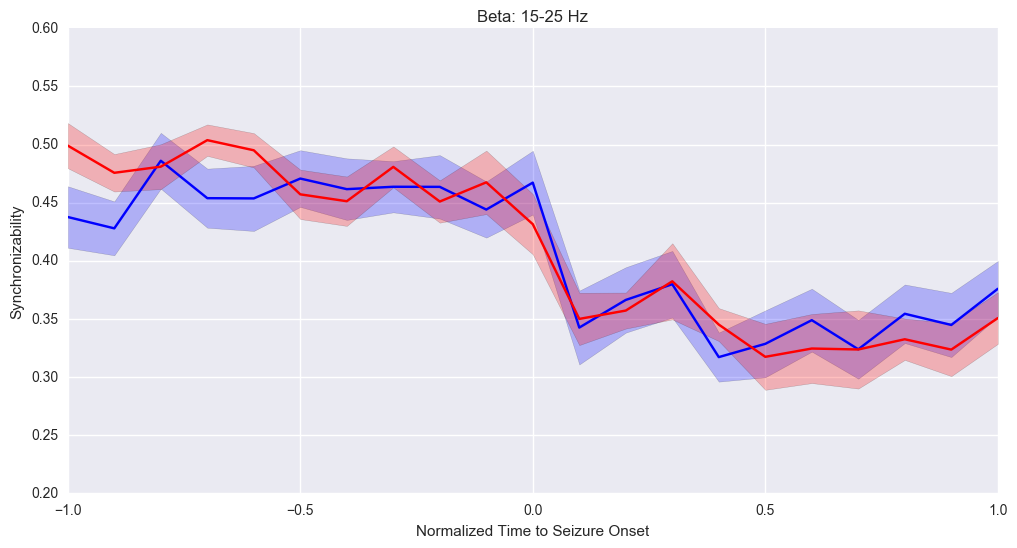

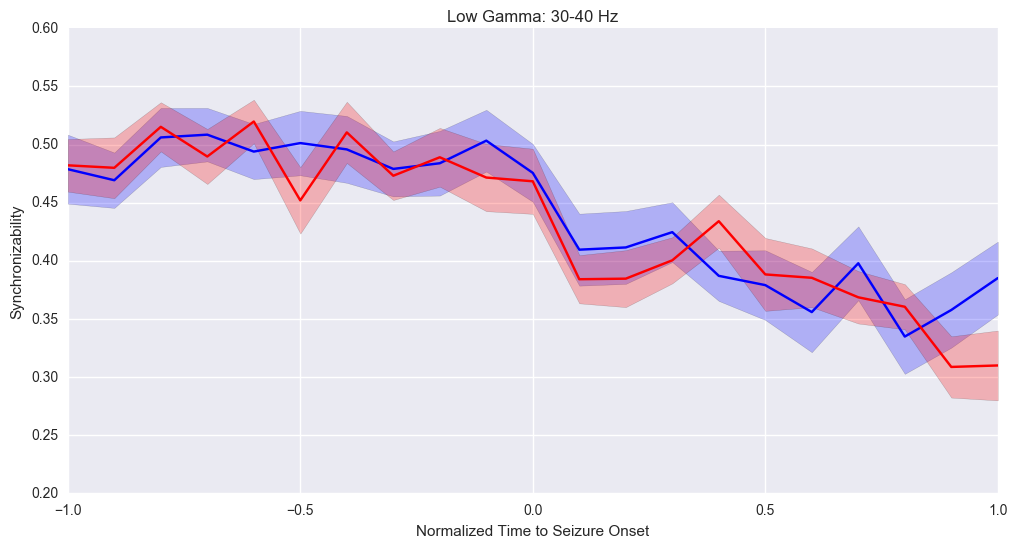

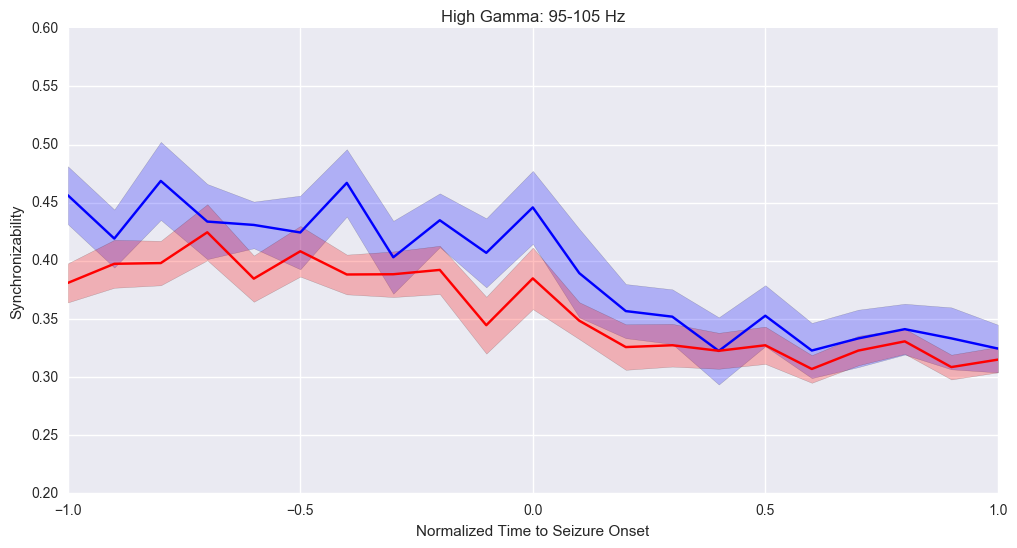

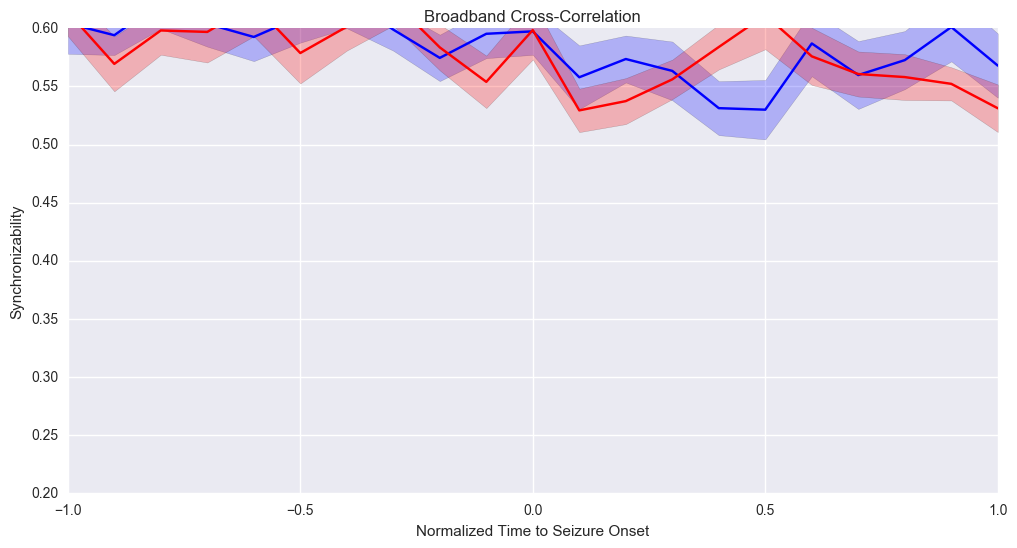

In [5]:
width = -1
for fconn in ['alphatheta','beta','lowgamma','highgamma','broadband_CC']:

    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta: 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta: 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma: 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma: 95-105 Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband Cross-Correlation'

    skip_chop = True
    skip_mayo = False
    skip_hup = False
    dilate_radius = 0
    all_base_sync = gather_base_sync_results(dilate_radius,fconn, skip_chop, skip_mayo)        
    all_base_sync = get_norm(all_base_sync, width=width)
    width = len(map(lambda x: x.values(), all_base_sync.values())[0][0])
    num_fts = width

    pt_iter = 0
    patient_idx = all_base_sync.keys()
    ft_matrix = np.zeros((sum(map(lambda x: bool(x), all_base_sync.values())),num_fts+2))

    out_txt = 'pt_id,' #First column
    index_col = []    

    for patient_id in sorted(patient_idx):
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            if not all_base_sync[patient_id]:
                continue
    #                 print patient_id
            index_col.append(patient_id)
            row_data = np.array((pt_iter+1,))    
            for pid,clips in sorted(all_base_sync.items(), key=lambda x:x[0]):                    
                if(pid != patient_id):
                    continue
                outcome = data['PATIENTS'][patient_id]['Outcome']

                avg_data = np.array(())                    
                for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                    res = clip_data                        
                    if(res.shape[0] == num_fts+1):
                        res = res[:num_fts]
                    try:                
                        avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                    except Exception:                
                        avg_data = np.reshape(res,(num_fts,1))                    
                avg_data = np.nanmedian(avg_data,axis=1)

                # Update row_data
                row_data = np.hstack((row_data,avg_data)) 

                # Update header
                if(pt_iter == 0):
                    for t in range(1,num_fts+1):
                        out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
            if(get_outcome(outcome) == 'Good'):        
                row_data = np.hstack((row_data,[0]))        
            else:
                row_data = np.hstack((row_data,[1]))
            if(row_data.shape[0] != num_fts+2):
                continue
            ft_matrix[pt_iter,:] = row_data
            pt_iter += 1
    
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    good_outcome_data = all_data[outcomex==0,:]
    poor_outcome_data = all_data[outcomex==1,:]

    good_outcome_data_err = scipy.stats.sem(good_outcome_data,axis=0,nan_policy='omit')
    # good_outcome_data_err_low = np.nanpercentile(good_outcome_data,2.5,axis=0)
    # good_outcome_data_err_high = np.nanpercentile(good_outcome_data,97.5,axis=0)


    poor_outcome_data_err = scipy.stats.sem(poor_outcome_data,axis=0,nan_policy='omit')
    # poor_outcome_data_err_low = np.nanpercentile(poor_outcome_data,2.5,axis=0)
    # poor_outcome_data_err_high = np.nanpercentile(poor_outcome_data,97.5,axis=0)

    plt.figure(dpi=1200,figsize=(12,6))
    plt.plot(np.linspace(-1.0,1.0,num_fts),np.nanmedian(good_outcome_data,axis=0),'b')
    plt.hold(True)
    plt.fill_between(np.linspace(-1.0,1.0,num_fts),np.nanmedian(good_outcome_data,axis=0)-good_outcome_data_err,np.nanmedian(good_outcome_data,axis=0)+good_outcome_data_err,facecolor='blue',alpha=0.25)
    # plt.fill_between(np.linspace(-1.0,1.0,num_fts),good_outcome_data_err_low,good_outcome_data_err_high,facecolor='blue',alpha=0.25)
    plt.plot(np.linspace(-1.0,1.0,num_fts),np.nanmedian(poor_outcome_data,axis=0), 'r')
    plt.fill_between(np.linspace(-1.0,1.0,num_fts),np.nanmedian(poor_outcome_data,axis=0)-poor_outcome_data_err,np.nanmedian(poor_outcome_data,axis=0)+poor_outcome_data_err,facecolor='red',alpha=0.25)
    # plt.fill_between(np.linspace(-1.0,1.0,num_fts),poor_outcome_data_err_low,poor_outcome_data_err_high,facecolor='red',alpha=0.25)
    plt.xlim(( -1.0, 1.0))
    plt.ylim((0.2, 0.6))
    plt.title(title)
    plt.xlabel('Normalized Time to Seizure Onset')
    plt.ylabel('Synchronizability')
    plt.grid(True)
    # plt.show()
    plt.savefig('../../fig/Figure2A_%s.svg'%fconn,bbox_inches='tight', format='svg', dpi=1200)

In [39]:
width = -1
for fconn in ['alphatheta','beta','lowgamma','highgamma','broadband_CC']:

    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta: 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta: 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma: 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma: 95-105 Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband Cross-Correlation'

    skip_chop = True
    skip_mayo = False
    skip_hup = False
    dilate_radius = 0
    all_base_sync = gather_base_sync_results(dilate_radius,fconn, skip_chop, skip_mayo)        
    all_base_sync = get_norm(all_base_sync, width=width)
    width = len(map(lambda x: x.values(), all_base_sync.values())[0][0])
    num_fts = width

    pt_iter = 0
    patient_idx = all_base_sync.keys()
    ft_matrix = np.zeros((sum(map(lambda x: bool(x), all_base_sync.values())),num_fts+2))

    out_txt = 'pt_id,' #First column
    index_col = []    

    for patient_id in sorted(patient_idx):
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            if not all_base_sync[patient_id]:
                continue
    #                 print patient_id
            index_col.append(patient_id)
            row_data = np.array((pt_iter+1,))    
            for pid,clips in sorted(all_base_sync.items(), key=lambda x:x[0]):                    
                if(pid != patient_id):
                    continue
                outcome = data['PATIENTS'][patient_id]['Outcome']

                avg_data = np.array(())                    
                for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                    res = clip_data                        
                    if(res.shape[0] == num_fts+1):
                        res = res[:num_fts]
                    try:                
                        avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                    except Exception:                
                        avg_data = np.reshape(res,(num_fts,1))                    
                avg_data = np.nanmedian(avg_data,axis=1)

                # Update row_data
                row_data = np.hstack((row_data,avg_data)) 

                # Update header
                if(pt_iter == 0):
                    for t in range(1,num_fts+1):
                        out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
            if(get_outcome(outcome) == 'Good'):        
                row_data = np.hstack((row_data,[0]))        
            else:
                row_data = np.hstack((row_data,[1]))
            if(row_data.shape[0] != num_fts+2):
                continue
            ft_matrix[pt_iter,:] = row_data
            pt_iter += 1

    ft_matrix = np.array(ft_matrix)
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    
    fpr,tpr,threshold = roc_curve(outcomex,np.nanmean(all_data[:,width/2:],axis=1))
    roc_auc = auc(fpr,tpr)
    print roc_auc
    p = curve_test(all_data[:,:all_data.shape[0]/2].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    print fconn,'pre',p
    p = curve_test(all_data[:,all_data.shape[0]/2:].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    print fconn,'seizure',p

0.422222222222
alphatheta pre 0.2133
alphatheta seizure 0.6022
0.522222222222
beta pre 0.5631
beta seizure 0.7931
0.444444444444
lowgamma pre 0.8359
lowgamma seizure 0.4256
0.288888888889
highgamma pre 0.1019
highgamma seizure 0.0787
0.433333333333
broadband_CC pre 0.5088
broadband_CC seizure 0.7963


<h1>Figure 4A. Synchronizability of Time-Varying Functional Networks (averaged across individual seizures) </h1>

In [29]:
width = -1
all_features = []
roc_results = []
for fconn in ['lowgamma']:

    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta: 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta: 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma: 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma: 95-105 Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband Cross-Correlation'

    skip_chop = True
    skip_mayo = False
    skip_hup = False
    dilate_radius = 0
    all_base_sync = gather_base_sync_results(dilate_radius,fconn)
    all_base_sync = get_norm(all_base_sync, width=width)
    width = len(map(lambda x: x.values(), all_base_sync.values())[0][0])
    num_fts = width

    clip_iter = 0
    patient_idx = all_base_sync.keys()
    ft_matrix = []

    out_txt = 'pt_id,' #First column
    index_col = []    
    clip_labels = []
    for patient_id in sorted(patient_idx):
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            if not all_base_sync[patient_id]:
                continue
    #                 print patient_id
            index_col.append(patient_id)
            
            for pid,clips in sorted(all_base_sync.items(), key=lambda x:x[0]):                    
                if(pid != patient_id):
                    continue
                outcome = data['PATIENTS'][patient_id]['Outcome']              
                # Create entry for each subtype
                for subtype in ['A', 'B', 'C', 'D']:
                    avg_data = np.array(())
                    for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                        stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip]['SeizurePhenotype']
                        if stype != subtype:
                            continue
                        res = clip_data                        
                        if(res.shape[0] == num_fts+1):
                            res = res[:num_fts]
                        try:                
                            avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                        except Exception:                
                            avg_data = np.reshape(res,(num_fts,1))                    
                    if patient_id == 'HUP107' and subtype == 'C':
                        print avg_data
                    # Check if subtype exists
                    if avg_data.shape[0] == 0:
                        continue
                    
                    #%DEBUG
#                     print patient_id, clip, avg_data.shape
                    avg_data = np.nanmedian(avg_data,axis=1)
    
                    # Update row_data
                    row_data = np.append([clip_iter+1],avg_data)
                    row_data = np.reshape(row_data, (row_data.shape[0],1))
                    # Update header
                    if(clip_iter == 0):
                        for t in range(1,num_fts+1):
                            out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
                    if(get_outcome(outcome) == 'Good'):        
                        row_data = np.append(row_data,[0])        
                    else:
                        row_data = np.append(row_data,[1])
                    row_data = np.reshape(row_data, (row_data.shape[0],1))
                    try:
                        all_data = np.hstack((all_data, np.reshape(row_data,(num_fts+2,1))))
                    except Exception:
                        all_data = row_data
                    clip_iter += 1
                    clip_labels.append(patient_id+subtype)
    ft_matrix = np.array(all_data).T
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    
    res= zip(clip_labels,np.nanmean(all_data[:,width/2:],axis=1)-np.nanmean(all_data[:,:width/2],axis=1))
    open('../../fig/tmp.csv','w').write('\n'.join(map(lambda x: '%s,%0.8f'%(x[0],x[1]),res)))

print res

[]
[(u'HUP064A', -0.12445504036271088), (u'HUP068A', -0.12139253384475479), (u'HUP068B', -0.12248353207909374), (u'HUP073A', -0.045848947533352391), (u'HUP073B', -0.042135181283590617), (u'HUP074A', -0.097446227222426463), (u'HUP074B', -0.087224239002174131), (u'HUP075A', -0.16216082855335995), (u'HUP078A', -0.10213499582986346), (u'HUP083A', -0.023277480466623479), (u'HUP083C', -0.19781041327173565), (u'HUP083D', 0.0025335768237069178), (u'HUP086A', -0.15140269127270867), (u'HUP088A', -0.19791628935945055), (u'HUP088B', -0.20316027051906865), (u'HUP088C', -0.11988540475778409), (u'HUP094A', -0.11023516390676236), (u'HUP105A', -0.12242474832646716), (u'HUP105B', -0.048766387611152651), (u'HUP106A', -0.088495532153064882), (u'HUP106B', -0.17195070920081007), (u'HUP106C', -0.15399001826593411), (u'HUP107A', -0.20682819822893522), (u'HUP107B', -0.049295040658361322), (u'HUP111A', -0.1420309492466203), (u'Study022A', -0.088968264197593405), (u'Study022B', -0.043452791327948603), (u'Study02

In [1]:
width = -1
for fconn in ['alphatheta','beta','lowgamma','highgamma','broadband_CC']:

    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta: 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta: 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma: 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma: 95-105 Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband Cross-Correlation'

    skip_chop = True
    skip_mayo = False
    skip_hup = False
    dilate_radius = 0
    all_base_sync = gather_base_sync_results(dilate_radius,fconn, skip_chop, skip_mayo)
    all_base_sync = get_norm(all_base_sync, width=width)
    width = len(map(lambda x: x.values(), all_base_sync.values())[0][0])
    num_fts = width

    clip_iter = 0
    patient_idx = all_base_sync.keys()
    ft_matrix = np.zeros((sum(map(lambda x: bool(x), all_base_sync.values())),num_fts+2))

    out_txt = 'pt_id,' #First column
    index_col = []    
    
    all_data = np.array(())

    for patient_id in sorted(patient_idx):
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            if not all_base_sync[patient_id]:
                continue
#             print patient_id
            index_col.append(patient_id)
            
            for pid,clips in sorted(all_base_sync.items(), key=lambda x:x[0]):
                if(pid != patient_id):
                    continue
                outcome = data['PATIENTS'][patient_id]['Outcome'] 
                
                # Create entry for each subtype
                for subtype in ['A', 'B', 'C', 'D']:
                    avg_data = np.array(())
                    for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                        stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip]['SeizurePhenotype']
                        if stype != subtype:
                            continue
                        res = clip_data                        
                        if(res.shape[0] == num_fts+1):
                            res = res[:num_fts]
                        try:                
                            avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                        except Exception:                
                            avg_data = np.reshape(res,(num_fts,1))                    
                    # Check if subtype exists
                    if avg_data.shape[0] == 0:
                        continue
                    
                    #%DEBUG
#                     print patient_id, clip, avg_data.shape
                    avg_data = np.nanmedian(avg_data,axis=1)
                        
                    # Update row_data
                    row_data = np.append([clip_iter+1],avg_data)
                    row_data = np.reshape(row_data, (row_data.shape[0],1))
                    # Update header
                    if(clip_iter == 0):
                        for t in range(1,num_fts+1):
                            out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
                    if(get_outcome(outcome) == 'Good'):        
                        row_data = np.append(row_data,[0])        
                    else:
                        row_data = np.append(row_data,[1])
                    row_data = np.reshape(row_data, (row_data.shape[0],1))
                    try:
                        all_data = np.hstack((all_data, np.reshape(row_data,(num_fts+2,1))))
                    except Exception:
                        all_data = row_data
                    clip_iter += 1
    ft_matrix = np.array(all_data).T
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    good_outcome_data = all_data[outcomex==0,:]
    poor_outcome_data = all_data[outcomex==1,:]

    good_outcome_data_err = scipy.stats.sem(good_outcome_data,axis=0,nan_policy='omit')
    # good_outcome_data_err_low = np.nanpercentile(good_outcome_data,2.5,axis=0)
    # good_outcome_data_err_high = np.nanpercentile(good_outcome_data,97.5,axis=0)


    poor_outcome_data_err = scipy.stats.sem(poor_outcome_data,axis=0,nan_policy='omit')
    # poor_outcome_data_err_low = np.nanpercentile(poor_outcome_data,2.5,axis=0)
    # poor_outcome_data_err_high = np.nanpercentile(poor_outcome_data,97.5,axis=0)
    font = {'family' : 'Raleway',
        'weight' : 'normal',
        'size'   : 20}
    matplotlib.rc('font', **font)
    matplotlib.rcParams['axes.titlesize'] = 36
    matplotlib.rcParams['axes.titleweight'] = 'bold'
    matplotlib.rcParams['axes.labelsize'] = 32
    matplotlib.rcParams['axes.labelweight'] = 'bold'
    matplotlib.rcParams['ytick.labelsize'] = 16
    matplotlib.rcParams['xtick.labelsize'] = 16
    matplotlib.rcParams['axes.labelcolor'] = 'black'
    
    plt.figure(dpi=1200,figsize=(10,6))
    plt.plot(np.linspace(-1.0,1.0,num_fts),np.nanmedian(good_outcome_data,axis=0),'b')
    plt.hold(True)
    plt.fill_between(np.linspace(-1.0,1.0,num_fts),np.nanmedian(good_outcome_data,axis=0)-good_outcome_data_err,np.nanmedian(good_outcome_data,axis=0)+good_outcome_data_err,facecolor='blue',alpha=0.25)
    # plt.fill_between(np.linspace(-1.0,1.0,num_fts),good_outcome_data_err_low,good_outcome_data_err_high,facecolor='blue',alpha=0.25)
    plt.plot(np.linspace(-1.0,1.0,num_fts),np.nanmedian(poor_outcome_data,axis=0), 'r')
    plt.fill_between(np.linspace(-1.0,1.0,num_fts),np.nanmedian(poor_outcome_data,axis=0)-poor_outcome_data_err,np.nanmedian(poor_outcome_data,axis=0)+poor_outcome_data_err,facecolor='red',alpha=0.25)
    # plt.fill_between(np.linspace(-1.0,1.0,num_fts),poor_outcome_data_err_low,poor_outcome_data_err_high,facecolor='red',alpha=0.25)
    plt.xlim(( -1.0, 1.0))    
    plt.ylim((0.2, 0.8))
    plt.plot([0,0],[0.2,0.8],color='m',linestyle=':')
    plt.yticks(np.arange(0.2,0.8,0.1))
    plt.title(title)
    plt.xlabel('Normalized Time to Seizure Onset')
    plt.ylabel('Synchronizability')
    plt.grid(True)
    
    # Make significance indicators
    fpr,tpr,threshold = roc_curve(outcomex,np.nanmean(all_data[:,width/2:],axis=1)-np.nanmean(all_data[:,:width/2],axis=1))    
    roc_auc = auc(fpr,tpr)
    pre_p = curve_test(all_data[:,:all_data.shape[0]/2].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    post_p = curve_test(all_data[:,all_data.shape[0]/2:].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    if pre_p < 0.001:
        plt.text(-0.65,0.65, '***',{'weight':'bold', 'size':22})
    elif pre_p < 0.01:
        plt.text(-0.65,0.65, '**',{'weight':'bold', 'size':22})
    elif pre_p < 0.05:
        plt.text(-0.65,0.65, '*',{'weight':'bold', 'size':22})
    elif pre_p < 0.1:
        plt.text(-0.65,0.65, 'p=%0.2f'%pre_p,{'weight':'normal', 'size':22})
    
    if post_p < 0.001:
        plt.text(0.35,0.65, '***',{'weight':'bold', 'size':22})
    elif post_p < 0.01:
        plt.text(0.35,0.65, '**',{'weight':'bold', 'size':22})
    elif post_p < 0.05:
        plt.text(0.35,0.65, '*',{'weight':'bold', 'size':22})
    elif post_p < 0.1:
        plt.text(0.35,0.65, 'p=%0.2f'%post_p,{'weight':'normal', 'size':22})
    
    plt.savefig('../../fig/Figure6A_%s.svg'%fconn,bbox_inches='tight', format='svg', dpi=1200)

NameError: name 'gather_base_sync_results' is not defined

In [12]:
width = -1
for fconn in ['alphatheta','beta','lowgamma','highgamma','broadband_CC']:

    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta: 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta: 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma: 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma: 95-105 Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband Cross-Correlation'

    skip_chop = True
    skip_mayo = False
    skip_hup = False
    dilate_radius = 0
    all_base_sync = gather_base_sync_results(dilate_radius,fconn, skip_chop, skip_mayo)
    all_base_sync = get_norm(all_base_sync, width=width)
    width = len(map(lambda x: x.values(), all_base_sync.values())[0][0])
    num_fts = width

    clip_iter = 0
    patient_idx = all_base_sync.keys()
    ft_matrix = np.zeros((sum(map(lambda x: bool(x), all_base_sync.values())),num_fts+2))

    out_txt = 'pt_id,' #First column
    index_col = []    
    
    all_data = np.array(())

    for patient_id in sorted(patient_idx):
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            if not all_base_sync[patient_id]:
                continue
    #                 print patient_id
            index_col.append(patient_id)
            
            for pid,clips in sorted(all_base_sync.items(), key=lambda x:x[0]):
                if(pid != patient_id):
                    continue
                outcome = data['PATIENTS'][patient_id]['Outcome'] 
                
                # Create entry for each subtype
                for subtype in ['A', 'B', 'C', 'D']:
                    avg_data = np.array(())
                    for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                        stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip]['SeizurePhenotype']
                        if stype != subtype:
                            continue
                        res = clip_data                        
                        if(res.shape[0] == num_fts+1):
                            res = res[:num_fts]
                        try:                
                            avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                        except Exception:                
                            avg_data = np.reshape(res,(num_fts,1))                    
                    # Check if subtype exists
                    if avg_data.shape[0] == 0:
                        continue
                    
                    #%DEBUG
#                     print patient_id, clip, avg_data.shape
                    avg_data = np.nanmedian(avg_data,axis=1)
                        
                    # Update row_data
                    row_data = np.append([clip_iter+1],avg_data)
                    row_data = np.reshape(row_data, (row_data.shape[0],1))
                    # Update header
                    if(clip_iter == 0):
                        for t in range(1,num_fts+1):
                            out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
                    if(get_outcome(outcome) == 'Good'):        
                        row_data = np.append(row_data,[0])        
                    else:
                        row_data = np.append(row_data,[1])
                    row_data = np.reshape(row_data, (row_data.shape[0],1))
                    try:
                        all_data = np.hstack((all_data, np.reshape(row_data,(num_fts+2,1))))
                    except Exception:
                        all_data = row_data
                    clip_iter += 1
    ft_matrix = np.array(all_data).T
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    
    fpr,tpr,threshold = roc_curve(outcomex,np.nanmean(all_data[:,width/2:],axis=1)-np.nanmean(all_data[:,:width/2],axis=1))    
    roc_auc = auc(fpr,tpr)
    print roc_auc

    p = curve_test(all_data[:,:all_data.shape[0]/2].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    print fconn,'pre',p
    p = curve_test(all_data[:,all_data.shape[0]/2:].T,np.where(outcomex==0)[0],np.where(outcomex==1)[0],10000)
    print fconn,'seizure',p

0.50625
alphatheta pre 0.1931
alphatheta seizure 0.7354
0.575
beta pre 0.6534
beta seizure 0.8327
0.60625
lowgamma pre 0.9608
lowgamma seizure 0.6566
0.6625
highgamma pre 0.8735
highgamma seizure 0.6148
0.63125
broadband_CC pre 0.5084
broadband_CC seizure 0.3703


<h1> Figure 6A. Change in synchronizability as a feature </h1>

alphatheta -0.0508547627716 0.959441252913
beta -0.610257153259 0.541691475059
lowgamma -0.864530967117 0.387296276462
highgamma -1.32222383206 0.1860936274
broadband_CC -1.0679500182 0.28554305835


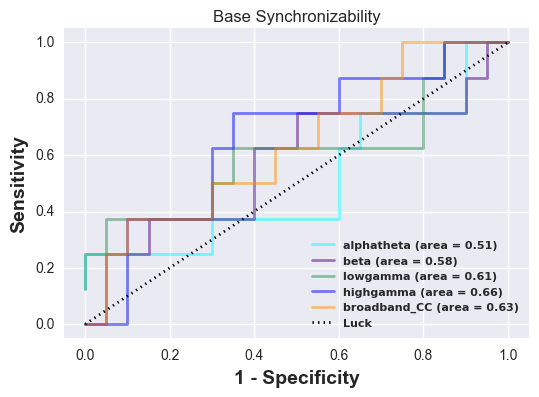

In [3]:
fig,axs = plt.subplots(1,1)
ax = axs
fig.set_size_inches((6,4))

width = -1
all_features = []
roc_results = []
for fconn in ['alphatheta','beta','lowgamma','highgamma','broadband_CC']:

    if(fconn == 'alphatheta'):
        title = 'Alpha/Theta: 5-15 Hz'
    if(fconn == 'beta'):
        title = 'Beta: 15-25 Hz'
    if(fconn == 'lowgamma'):
        title = 'Low Gamma: 30-40 Hz'
    if(fconn == 'highgamma'):
        title = 'High Gamma: 95-105 Hz'
    if(fconn == 'broadband_CC'):
        title = 'Broadband Cross-Correlation'

    skip_chop = True
    skip_mayo = False
    skip_hup = False
    dilate_radius = 0
    all_base_sync = gather_base_sync_results(dilate_radius,fconn, skip_chop, skip_mayo)
    all_base_sync = get_norm(all_base_sync, width=width)
    width = len(map(lambda x: x.values(), all_base_sync.values())[0][0])
    num_fts = width

    clip_iter = 0
    patient_idx = all_base_sync.keys()
    ft_matrix = np.zeros((sum(map(lambda x: bool(x), all_base_sync.values())),num_fts+2))

    out_txt = 'pt_id,' #First column
    index_col = []    
    
    all_data = np.array(())

    for patient_id in sorted(patient_idx):
            if(skip_chop and 'CHOP' in patient_id):
                continue
            if(skip_mayo and 'Study' in patient_id):
                continue
            if(skip_hup and 'HUP' in patient_id):
                continue
            if not all_base_sync[patient_id]:
                continue
    #                 print patient_id
            index_col.append(patient_id)
            
            for pid,clips in sorted(all_base_sync.items(), key=lambda x:x[0]):
                if(pid != patient_id):
                    continue
                outcome = data['PATIENTS'][patient_id]['Outcome'] 
                
                # Create entry for each subtype
                for subtype in ['A', 'B', 'C', 'D']:
                    avg_data = np.array(())
                    for clip, clip_data in sorted(clips.items(), key=lambda x:x[0]):
                        stype = data['PATIENTS'][patient_id]['Events']['Ictal'][clip]['SeizurePhenotype']
                        if stype != subtype:
                            continue
                        res = clip_data                        
                        if(res.shape[0] == num_fts+1):
                            res = res[:num_fts]
                        try:                
                            avg_data = np.hstack((avg_data,np.reshape(res,(num_fts,1))))
                        except Exception:                
                            avg_data = np.reshape(res,(num_fts,1))                    
                    # Check if subtype exists
                    if avg_data.shape[0] == 0:
                        continue
                    
                    #%DEBUG
#                     print patient_id, clip, avg_data.shape
                    avg_data = np.nanmedian(avg_data,axis=1)
                        
                    # Update row_data
                    row_data = np.append([clip_iter+1],avg_data)
                    row_data = np.reshape(row_data, (row_data.shape[0],1))
                    # Update header
                    if(clip_iter == 0):
                        for t in range(1,num_fts+1):
                            out_txt += 'base_sync_'+str(t)+'_%s,'%fconn
                    if(get_outcome(outcome) == 'Good'):        
                        row_data = np.append(row_data,[0])        
                    else:
                        row_data = np.append(row_data,[1])
                    row_data = np.reshape(row_data, (row_data.shape[0],1))
                    try:
                        all_data = np.hstack((all_data, np.reshape(row_data,(num_fts+2,1))))
                    except Exception:
                        all_data = row_data
                    clip_iter += 1
    ft_matrix = np.array(all_data).T
    all_data = ft_matrix[:,1:width+1]
    outcomex = ft_matrix[:,width+1]
    
    good_outcome_feature = np.nanmean(all_data[outcomex==0,width/2:],axis=1)-np.nanmean(all_data[outcomex==0,:width/2],axis=1)
    poor_outcome_feature = np.nanmean(all_data[outcomex==1,width/2:],axis=1)-np.nanmean(all_data[outcomex==1,:width/2],axis=1)
    all_features.append(good_outcome_feature)
    all_features.append(poor_outcome_feature)
    s,p = scipy.stats.ranksums(good_outcome_feature, poor_outcome_feature)
    print fconn, s,p
    if p < 0.05:
        print fconn, s,p
    
    fpr,tpr,threshold = roc_curve(outcomex,np.nanmean(all_data[:,width/2:],axis=1)-np.nanmean(all_data[:,:width/2],axis=1))    
    roc_auc = auc(fpr,tpr)
    roc_results.append((fconn,roc_auc,fpr,tpr))
    
# ax.boxplot(all_features)

# ax.set_xticks([1,2,3,4,5,6,7,8,9,10])
# ax.set_xticklabels(['Good','Poor','Good','Poor','Good','Poor','Good','Poor','Good','Poor'],fontdict={'size':8,'weight':'bold'},rotation='vertical')
# ax.set_ylim([-0.3,0.05])
# for ii in range(1,10,2):
#     ax.get_xticklabels()[ii].set_color('black')
# for ii in range(0,10,2):
#     ax.get_xticklabels()[ii].set_color('darkgray')
# ax.text(0.75,-0.25,'Alpha/Theta:\n 5-15 Hz',fontdict={'size':10,'weight':'normal'})
# ax.text(2.75,-0.25,'Beta:\n 15-25 Hz',fontdict={'size':10,'weight':'normal'})
# ax.text(4.75,-0.25,'Low Gamma:\n 30-40 Hz',fontdict={'size':10,'weight':'normal'})
# ax.text(6.75,-0.25,'High Gamma:\n 95-105 Hz',fontdict={'size':10,'weight':'normal'})
# ax.text(8.75,-0.25,'Broadband\n Cross-\nCorrelation',fontdict={'size':10,'weight':'normal'})
# ax.set_ylabel('Change in Synchronizability \n(pre-ictal to ictal)',fontdict={'size':14,'weight':'bold'})

# ax = axs[1]
colors = ['cyan', 'indigo', 'seagreen', 'blue', 'darkorange', 'yellow']
i = 0
for fconn, roc_auc, fpr, tpr in roc_results:
    ax.plot(fpr, tpr, lw=2, color=colors[i], linestyle='-', label = '%s (area = %0.2f)'%(fconn,roc_auc), alpha=0.5)
    ax.hold(True)
    i += 1
# Plot the ROC curve for luck along with area
ax.plot([0, 1], [0, 1], linestyle=':', lw=2, color='k', label='Luck')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])

ax.set_xlabel('1 - Specificity',fontdict={'size':14,'weight':'bold'})
ax.set_ylabel('Sensitivity',fontdict={'size':14,'weight':'bold'})
ax.legend(loc="lower right",prop={'size':8,'weight':'bold', 'family':'normal'})

plt.title('Base Synchronizability')
plt.savefig('../../fig/Figure6A.svg',bbox_inches='tight', format='svg', dpi=1200)

<h1> e01A. Cross-Validation using basic connectivity features </h1>

In [ ]:
rs = 25
# Parameters
# Load DataFrame
df1 = pd.read_csv('~/gdrive/aim3/code/data/e01A_broadband_CC.csv')
# df2 = pd.read_csv('~/gdrive/aim3/code/data/e01A_alphatheta.csv')
# df3 = pd.read_csv('~/gdrive/aim3/code/data/e01A_beta.csv')
# df4 = pd.read_csv('~/gdrive/aim3/code/data/e01A_lowgamma.csv')
# df5 = pd.read_csv('~/gdrive/aim3/code/data/e01A_highgamma.csv')
# df = pd.concat([df1, df2, df3, df4, df5],axis=1)
df = df1

if(True):
    df = df.dropna()

# Generate feature matrix and target vectors
print 'Generating feature matrix ...'
X = np.array(df[df.columns.difference(['Unnamed: 0','pt_id','Outcome'])])
print X.shape
# y = np.array(df.Outcome.iloc[:,0])
y = np.array(df.Outcome)


if(False):
    imp = Imputer(missing_values = 'NaN', strategy='mean', axis=0)
    X = imp.fit(X).transform(X)    


# Build a Random Forest with 1000 estimators
classifier_VR = RandomForestClassifier(n_estimators=1000, random_state=rs)
classifier_VR = SVC(kernel='linear', probability=True, random_state=rs)

# Compute k-fold cross-validation True Positive Rate (TPR) and False Positive Rate (FPR)
# to generate ROC curves.
print 'Performing cross validation ...'
n_splits = 3
cv = StratifiedKFold(n_splits=n_splits, random_state=rs)
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

from itertools import cycle
colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2
i = 0

# for (train, test) in cv.split(X,y):
for (train, test), color in zip(cv.split(X, y), colors):
    # Ignore any folds that do not have any poor outcomes 
    # to maintain representation of entire dataset.
    if(sum(y[test]) == 0):
        print train,test
        continue
    probas_ = classifier_VR.fit(X[train], y[train]).predict_proba(X[test])
    
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.hold(True)
    plt.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',label='Luck')

# Compute mean Area Under Curve (AUC)    
print 'Computing AUC of ROC ...'
mean_tpr /= n_splits
mean_tpr[-1] = 1.0
mean_auc_VR = auc(mean_fpr, mean_tpr)
sigma_auc_VR = 2*np.sqrt(mean_auc_VR*(1-mean_auc_VR)/4)

plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc_VR, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Compute Mean AUC and Confidence interval using \sigma_max
print "Mean AUC: %0.3f $\pm$ %0.3f"%(mean_auc_VR,sigma_auc_VR)

<h2> Create developmental and validation cohorts </h2>

In [ ]:
# Load DataFrame
# df1 = pd.read_csv('~/gdrive/aim3/code/data/e01A_broadband_CC.csv')
# df2 = pd.read_csv('~/gdrive/aim3/code/data/e01A_alphatheta.csv')
# cols_to_use = df2.columns.difference(df1.columns)
# df = pd.merge(df1, df2[cols_to_use], left_index=True, right_index=True, how='outer')

# df3 = pd.read_csv('~/gdrive/aim3/code/data/e01A_beta.csv')
# cols_to_use = df3.columns.difference(df.columns)
# df = pd.merge(df, df3[cols_to_use], left_index=True, right_index=True, how='outer')

# df4 = pd.read_csv('~/gdrive/aim3/code/data/e01A_lowgamma.csv')
# cols_to_use = df4.columns.difference(df.columns)
# df = pd.merge(df, df4[cols_to_use], left_index=True, right_index=True, how='outer')

# df5 = pd.read_csv('~/gdrive/aim3/code/data/e01A_highgamma.csv')
# cols_to_use = df5.columns.difference(df.columns)
# df = pd.merge(df, df5[cols_to_use], left_index=True, right_index=True, how='outer')
df2 = pd.read_csv('~/gdrive/aim3/code/data/e01A_alphatheta.csv')
df = df2

df = df.dropna()

# Determine randomly generated train and test split 
rs = ShuffleSplit(n_splits=1, test_size= 0.33)
for train_index, test_index in rs.split(df['Unnamed: 0']):
    train = train_index
    test = test_index

train_ptx = ['Study017','HUP083','CHOP42','CHOP45','CHOP20','CHOP08','CHOP43','CHOP40','Study016','Study020','CHOP46','HUP078','HUP073','HUP075','Study012','HUP070','Study022']
test_ptx = ['CHOP47','CHOP27','HUP080','Study029','Study028','HUP086','HUP074','HUP082','Study019']
train = []
test = []
for ii, pt in enumerate(df['Unnamed: 0']):
    if(pt in train_ptx):
        train.append(ii)
    elif(pt in test_ptx):
        test.append(ii)
             
#train = [19, 23, 16, 17, 13, 11, 21, 20, 18, 1, 9, 4, 7, 6, 15, 8,  0]
#test = [10, 12, 25,  2,  3, 22,  5, 24, 14]
train_idx = df.iloc[train,:]['Unnamed: 0']
test_idx = df.iloc[test,:]['Unnamed: 0']
print train_idx, test_idx, df.iloc[test,:].Outcome


<h2> Create the feature matrix $X$ and target outcome $y$ for all 4 models </h2>

In [ ]:
df4 = df

# Generate feature matrix and target vectors
print 'Generating feature matrix ...'
df4_train_idx = np.where(df4['Unnamed: 0'].isin(train_idx))
df4_test_idx = np.where(df4['Unnamed: 0'].isin(test_idx))
X4 = np.array(df4[df4.columns.difference(['Unnamed: 0','pt_id','Outcome'])])
y4 = np.array(df4.Outcome)
X4_labels = df4.columns.difference(['Unnamed: 0','pt_id','Outcome'])

<h3> Perform feature reduction for each model</h3>

In [ ]:
# Parameters
k1 = 5 # Number of features remaining after first round of feature reduction
# k2 = 350 # Number of features remaining after second round of feature reduction

# Build a Random Forest with 5000 estimators
classifier4 = RandomForestClassifier(n_estimators=1000)

## Do feature reduction on Model 4
print 'Model 4 ..................'
X = np.copy(X4)
y = np.copy(y4)

# Perform the first prune using ANOVA F test using mutual information
print 'Feature reduction to %i features ...'%(min(k1,X.shape[1]))
prune1 = SelectKBest(mutual_info_classif, k=min(k1,X.shape[1]))
X = prune1.fit_transform(X,y)
X4_labels = X4_labels[prune1.get_support()]
X4_pruned = X

# # Perform a second prune by selecting features optimally branched using the classifier
# print 'Second round of feature reduction ...'
# clf = classifier4.fit(X,y)
# model = SelectFromModel(clf, prefit=True)
# X = model.transform(X)
# X4_labels = X4_labels[model.get_support()]

# # Generate polynomial (degree 2) with interaction term feature set to account 
# # for non-linear combinations.
# # This will include cross-interaction terms to take into account non-linear combinations 
# # of clinical variables.
# print 'Generating polynomial combination of features ...'
# poly = PolynomialFeatures(2)
# X = poly.fit_transform(X)
# X4_labels = np.array(poly.get_feature_names(X4_labels))

# # Perform the third prune using ANOVA F test using mutual information
# print 'Final round of feature reduction to %i features ...'%k2
# prune2 = SelectKBest(mutual_info_classif, k=k2)
# X = prune2.fit_transform(X,y)
# X4_pruned = X
# X4_labels = X4_labels[prune2.get_support()]

<h3> Measure ROC and plot </h3>

In [ ]:
colors = ['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange']
lw = 2

# Train and test Model 4
X4_train = np.squeeze(X4_pruned[df4_train_idx,:])
y4_train = y4[df4_train_idx]
X4_test = np.squeeze(X4_pruned[df4_test_idx,:])
y4_test = y4[df4_test_idx]
y4_hat = classifier4.fit(X4_train,y4_train).predict_proba(X4_test)
fpr, tpr, thresholds = roc_curve(y4_test,y4_hat[:,1])
roc_auc = auc(fpr, tpr)
i = 4
plt.plot(fpr, tpr, lw=lw, color=colors[i], linestyle='--', label = 'Model %d (area = %0.2f)'%(i,roc_auc), alpha=0.5)
# Save Model 4 for model persistence
# joblib.dump(classifier4, 'classifier4.pkl')

# Plot the ROC curve for luck along with area
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.title('Receiver operating characteristic')
plt.xlabel('False Postive Rate')
plt.ylabel('Trupe Postive Rate')
plt.legend(loc="lower right")
plt.show()

In [ ]:
train_idx, test_idx, df4['Unnamed: 0'].iloc[df4_test_idx], y4_hat, y4_test

<h1> Feature Learning </h1>

In [ ]:
# Compute feature importances
clf4 = classifier4

def _helper(job):
    '''
    This helper function runs one instance of model fitting and returns the top feature importances and their name.
    '''    
    classifier,X_labels,all_labels,importances,K = job
    print K
    # Sort feature importances
    importances = classifier.feature_importances_
    std = np.std([tree.feature_importances_ for tree in classifier4.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Print all feature importances
    fnames = []
    for f in range(K):
        fname = X4_labels[indices[f]]
        fnames.append((fname,importances[indices[f]]))
        return fnames

    
# Parallel version
n_iter = 100
K = 4500
    
def run_jobs(clf, X_train, y_train, X_labels, all_labels, K):
    '''
    This function runs n_iter instances of model fitting and keeps track of the top $K$ features. 
    This function uses multiple cores to speed up computation.
    '''
    jobs = []
    
    for n in range(n_iter):
        print n
        clf.fit(X_train, y_train)
        importances = clf.feature_importances_
        classifier = clf    
        jobs.append((classifier,X_labels,all_labels,importances,K))
    return jobs
    return_list = []
    n_proc = 40
    pool = Pool(n_proc)
    return_list = map(_helper, jobs)
    pool.close()
    return return_list

clf = clf4
X_train = X4_train
y_train = y4_train
X_labels = X4_labels
all_labels = df4.columns.difference(['Unnamed: 0','id','outcome_binary'])
return_list4 = run_jobs(clf, X_train, y_train, X_labels, all_labels, K)

In [ ]:
jobs = return_list4
all_importances = []
for job in jobs:
    all_importances.append(job[3])
all_importances = np.array(all_importances)
print all_importances.shape
importances = np.mean(all_importances,axis=0)
indices = np.argsort(importances)[::-1]

# Print all feature importances
fnames = []
for f in range(K):
    fname = X4_labels[indices[f]]
    fnames.append((fname,importances[indices[f]]))
lines = []
for fname, val in fnames:
    lines.append('%s,%s'%(fname,val))

In [ ]:
import sys
import glob
import json
import time

for fconn in ['broadband_CC','alphatheta','beta','lowgamma','highgamma']:
    skip_chop = False
    skip_mayo = False
    skip_hup = False
    window = 1
    
    # Load DataFrame
    df = pd.read_csv('~/gdrive/aim3/code/data/e01A_%s.csv'%fconn)
    
    good = np.array(df[df.Outcome==0][sorted(df.columns.difference(['Unnamed: 0','Outcome','pt_id']),key=lambda x: int(x.split('_')[2]))]).T
    poor = np.array(df[df.Outcome==1][sorted(df.columns.difference(['Unnamed: 0','Outcome','pt_id']),key=lambda x: int(x.split('_')[2]))]).T

    times = np.arange(-300.0,600,window)*1.0/60

    base_sync = []
    for k in good:
        base_sync.append(np.nanmean(k[~np.isnan(k)]))
#     base_sync = base_sync[:-1]    
    
    error = scipy.stats.sem(good.T,nan_policy='omit')    
#     error = error[:-1]
#     print len(base_sync), times.shape, error.shape
    plt.plot(times,base_sync,'b-')
    plt.fill_between(times,base_sync-error,base_sync+error,facecolor='blue',alpha=0.25)
    plt.hold(True)

    base_sync = []
    for k in poor:
        base_sync.append(np.nanmean(k[~np.isnan(k)]))
#     base_sync = base_sync[:-1]
    error = scipy.stats.sem(poor.T,nan_policy='omit')
#     error = error[:-1]
    plt.plot(times,base_sync,'r-')
    plt.fill_between(times,base_sync-error,base_sync+error,facecolor='red',alpha=0.25)
    
    ##### PROCESS CSV RF FEATS
#     lines = open(os.path.expanduser('~/gdrive/tmp/aim3/rf_feats.csv'),'r').readlines()
    max_val = np.max(map(lambda x: float(x.split(',')[1]),lines))
    for line in lines:
        ft = line.split(',')[0]
        val = float(line.split(',')[1])
#         print ft,val
        ft_time = int(ft.split('_')[2])
        ft_fconn = ft.split('_')[3]
        if(ft_fconn == fconn or ft_fconn in fconn):
#             print fconn, ft_fconn, ft_time,val
            plt.fill_between([(ft_time-5-300)/60.0, (ft_time+5-300)/60.0], np.min(base_sync-error)-np.abs(np.min(base_sync-error))*0.2, np.max(base_sync+error)+np.abs(np.max(base_sync+error))*0.5, facecolor=(val,1-val,1-val),edgecolor=(val,1-val,1-val),alpha=min(val/max_val,1))
            pass
        

    # plt.xticks(map(lambda x: x+1, range(times.shape[0]))[::2],times[::2])
    # plt.yticks([])
    plt.xlabel('Time (min.)')
    plt.ylabel('$sync_{base}(t)$')
    plt.xlim([-5.0,10.0])
    plt.ylim([np.min(base_sync-error)-np.abs(np.min(base_sync-error))*0.2, np.max(base_sync+error)+np.abs(np.max(base_sync+error))*0.5])
    plt.title('$sync_{base}(t)$ in %s connectivity of all clips'%(fconn))
    plt.legend(['Good Outcome','Poor Outcome'])
#     plt.show()
    fig = plt.gcf()
    fig.set_size_inches(18.5,2.11)
    fig.savefig(os.path.expanduser('~/gdrive/aim3/fig/e01A.ROZ_delta_clip_%s_with_fts.png'%(fconn)),dpi=100,bbox_inches='tight')
    plt.hold(False)